**LSE Data Science Institute | DS105M 2022 Week11**

**Topic:** Applications: Sentiment analysis, topic modelling and social networks

**Author:** [@jonjoncardoso](github.com/jonjoncardoso)

**Date:** 6 December 2022

---

Obs: If you did not attend the lecture, you might notice a few gaps in your understanding when following this notebook. Watch the lecture recording.

In [1]:
%config InlineBackend.figure_format = 'svg'

# What are networks?



Let's look at the famous karate network.

Source: from the [igraph tutorials](https://igraph.readthedocs.io/en/stable/tutorials/visualize_communities.html).

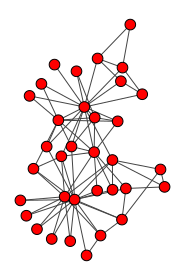

In [41]:
import igraph as ig
g = ig.Graph.Famous("Zachary")

fig, ax = plt.subplots()
ig.plot(
    g,
    palette=palette,
    edge_width=1,
    target=ax,
    vertex_size=0.3,
)

plt.show()

In [43]:
communities = g.community_edge_betweenness()
communities = communities.as_clustering()

In [46]:
pd.Series(communities)

0               [0, 1, 3, 7, 11, 12, 13, 17, 19, 21]
1                            [2, 24, 25, 27, 28, 31]
2                                  [4, 5, 6, 10, 16]
3    [8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]
4                                                [9]
dtype: object

**Plot with communities**

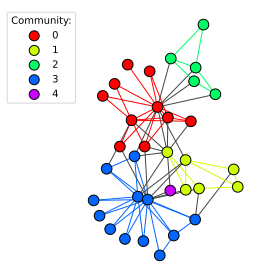

In [47]:
num_communities = len(communities)
palette = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    g.vs[community]["color"] = i
    community_edges = g.es.select(_within=community)
    community_edges["color"] = i

ig.plot(g)

fig, ax = plt.subplots()
ig.plot(
    communities,
    palette=palette,
    edge_width=1,
    target=ax,
    vertex_size=0.3,
)

# Create a custom color legend
legend_handles = []
for i in range(num_communities):
    handle = ax.scatter(
        [], [],
        s=100,
        facecolor=palette.get(i),
        edgecolor="k",
        label=i,
    )
    legend_handles.append(handle)
ax.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax.transAxes,
)
plt.show()

👀 https://networkkarate.tumblr.com/

I will illustrate how to construct a network using Twitter data.

# Working with Twitter Data

We will use [tweepy](https://docs.tweepy.org/en/stable/getting_started.html) library to access Twiter API.

The first thing we have to do is authenticate:

## 🚨🚨🚨🚨KEEP SECRETS OUT! 🚨🚨🚨🚨

EXTREMELY EXTREMELY IMPORTANT ADVICE:

- Don't use your SSH keys ANYWHERE in this notebook. Also, don't put them on Github either!!!
- Instead, create a `config.py` file somewhere outside this project (or .gitignore this file). See for example [this Stackoverflow link](https://stackoverflow.com/a/25501861/843365)

In [34]:
import config # This loads the content of the config.py file. If this throws an error, it is because you haven't created a config.py!
import tweepy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from plotnine import *

## Establish a connection

In [3]:
client = tweepy.Client(bearer_token=config.bearer_token, 
                       consumer_key=config.api_key, 
                       consumer_secret=config.api_key_secret, 
                       access_token=config.access_token, 
                       access_token_secret=config.access_token_secret)

## What are people talking about LSE on Twitter?

**Grab 10000 tweets**

In [4]:
tweet_fields=["id", "text", "attachments", "author_id", "context_annotations", "conversation_id", 
              "created_at", "entities", "in_reply_to_user_id", "lang", "public_metrics", "geo"]

In [5]:
lse_tweets = [tweet for tweet in tweepy.Paginator(client.search_recent_tweets, 
                                                  query="London School of Economics", 
                                                  tweet_fields=tweet_fields,
                                                  user_fields="location",
                                                  limit=10000).flatten()]

**Who tweeted that?**

In [6]:
client.get_user(id=lse_tweets[0].author_id)

Response(data=<User id=810782137 name=11D username=_11di_>, includes={}, errors=[], meta={})

# Let's create a `tidy` dataframe

In [7]:
df = pd.DataFrame([{field: tweet[field]  for field in tweet_fields} for tweet in lse_tweets])
df["in_reply_to_user_id"] = df["in_reply_to_user_id"].fillna(-1).astype(np.int64)
df.head()

,id,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,in_reply_to_user_id,lang,public_metrics,geo
0,1600166527407312899,@vajrayudha11 @velapuntea This page has the in...,None,810782137,"[{'domain': {'id': '46', 'name': 'Business Tax...",1600154292890914816,2022-12-06 16:33:24+00:00,"{'mentions': [{'start': 0, 'end': 13, 'usernam...",738352793791041536,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None
1,1600165755382747142,the backlash and opprobrium he received didn’t...,None,222496725,"[{'domain': {'id': '131', 'name': 'Unified Twi...",1600165752807378944,2022-12-06 16:30:20+00:00,None,222496725,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None
2,1600165416822722562,including “leaders of the socio-cultural group...,None,222496725,"[{'domain': {'id': '131', 'name': 'Unified Twi...",1600165410116030471,2022-12-06 16:28:59+00:00,"{'annotations': [{'start': 77, 'end': 85, 'pro...",222496725,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None
3,1600163304634142727,@PitonGigaton @DiscoverChile2 @24HorasTVN Clar...,None,1582381019558191109,"[{'domain': {'id': '131', 'name': 'Unified Twi...",1600147753467887617,2022-12-06 16:20:36+00:00,"{'mentions': [{'start': 0, 'end': 13, 'usernam...",1239228576324608000,es,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None
4,1600160000139464714,RT @INCAssam: Warm tributes to Dr Bhimrao Ambe...,None,1057719715970220032,"[{'domain': {'id': '131', 'name': 'Unified Twi...",1600160000139464714,2022-12-06 16:07:28+00:00,"{'mentions': [{'start': 3, 'end': 12, 'usernam...",-1,en,"{'retweet_count': 7, 'reply_count': 0, 'like_c...",None


**How many samples were returned?**

In [8]:
df.shape

(1572, 12)

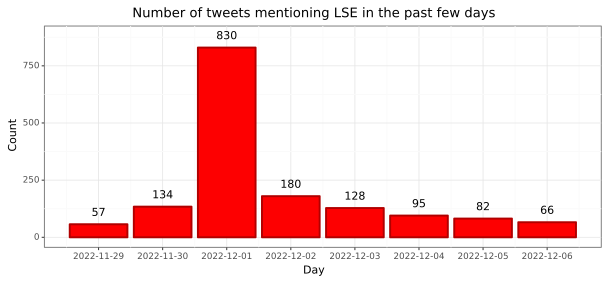

<ggplot: (170862156617)>

In [9]:
plot_df = (
     df.groupby(pd.Grouper(key="created_at", freq='1D'))
       .apply(lambda x: pd.Series({"count": len(x), "pctg": f"{100*(len(x)/df.shape[0]):.2f} %"})).reset_index()
)

g = (
    ggplot(plot_df, aes(x="created_at", y="count", label="count"))
    + geom_col(fill="#fd0001", color="#b10000", size=1.1)
    + geom_text(aes(y="count+50"))

    + theme_bw()
    + theme(figure_size=[10, 4]) 
    + labs(x="Day", y="Count", title="Number of tweets mentioning LSE in the past few days")
)

g

**How many tweets are "conversation starters"? That is, tweets that are not replies or retweets**

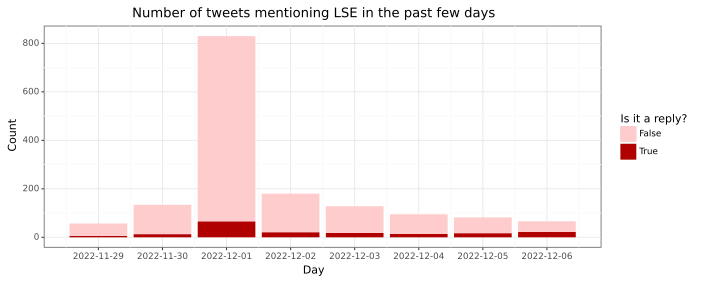

<ggplot: (170862272729)>

In [10]:
plot_df = (
     df.assign(is_reply=lambda x: x['in_reply_to_user_id'] != -1)
       .groupby([pd.Grouper(key="created_at", freq='1D'), "is_reply"])
       .apply(lambda x: pd.Series({"count": len(x), "pctg": f"{100*(len(x)/df.shape[0]):.2f} %"})).reset_index()
)

g = (
    ggplot(plot_df, aes(x="created_at", y="count", fill="is_reply"))
    + geom_col()

    # Set colors manually
    + scale_fill_manual(name="Is it a reply?", values=["#fecccc", "#b10000"])
    + theme_bw()
    + theme(figure_size=[10, 4]) 
    + labs(x="Day", y="Count", title="Number of tweets mentioning LSE in the past few days")
)

g

**What does that mean in numbers?**

In [11]:
df.assign(is_reply=lambda x: x['in_reply_to_user_id'] != -1)["is_reply"].value_counts()

False    1395
True      177
Name: is_reply, dtype: int64

# Select users

**Who are the usernames involved in our data?**

In [12]:
all_author_ids = df["author_id"].unique()
users_in_reply = df["in_reply_to_user_id"].unique()[1:]

In [13]:
all_authors = list(set(all_author_ids).union(users_in_reply))
len(all_authors)

1569

**Twitter API will not let me consult info about all of these people quickly. So let me show you a simpler/smaller example.**

## Grab users involved in our data

Let's create a "reply" network. We will not have a lot of data but this should be easy enough to illustrate how to create a network.

In [14]:
df[["author_id", "in_reply_to_user_id"]].dropna()

,author_id,in_reply_to_user_id
0,810782137,738352793791041536
1,222496725,222496725
2,222496725,222496725
3,1582381019558191109,1239228576324608000
4,1057719715970220032,-1
...,...,...
1567,712383019403894786,-1
1568,2321131837,-1
1569,3375847973,-1
1570,6266142,-1


In [15]:
df_network = df[["author_id", "in_reply_to_user_id"]].query("in_reply_to_user_id != -1").dropna()

In [16]:
df_network["author_id"] = df_network["author_id"].astype(str)
df_network["in_reply_to_user_id"] = df_network["in_reply_to_user_id"].astype(str)

**Let's do something similar to what we did last week and combine all author ids**

In [17]:
unique_authors = list(set(df_network["author_id"]).union(set(df_network["in_reply_to_user_id"])))
len(unique_authors)

274

## Augment the data: grab @\<username\>

**Now, let's do the same we did last week and grab the authors' @**

In [18]:
first_usernames  = client.get_users(ids=unique_authors[0:100])
second_usernames = client.get_users(ids=unique_authors[100:200])
third_usernames = client.get_users(ids=unique_authors[201:])

In [19]:
all_users_returned = first_usernames.data + second_usernames.data + third_usernames.data

In [20]:
def extract_user_data(user):
    
    return pd.DataFrame({"name": user.name, "username" : f"@{user.username}"},index=[user.id])

df_user_info = pd.concat([extract_user_data(user) for user in all_users_returned])
df_user_info

,name,username
238046285,MargB20 #REJOINER 🇪🇺🏴󠁧󠁢󠁥󠁮󠁧󠁿🔶 #FBPE #FF,@margb38
1396470558204829697,Scotonomics,@Scotonomics1
32981305,E Friend,@efriendsf
1177288662234607616,NothingShocksMeNow #JoinEU #SaveOurNHS #ToryLies,@HowtonTayler
1456228393234493446,Salina Reddy,@ReddySalina
...,...,...
1166775072280973314,It's too hot today,@itstoohottoday1
1513443087883898881,Muhammad Hassan,@islamorg_
19921244,Soily Sound,@soilysound
1138198502276784128,The Citizens,@allthecitizens


## Who follows who?

In [21]:
client.get_users_followers(unique_authors[0])

TooManyRequests: 429 Too Many Requests
Too Many Requests

In [ ]:
client.get_users_following(unique_authors[0])

# Building an ego network

In [22]:
current_author = int(unique_authors[0])

df_user_info.loc[current_author,:]["username"]

'@margb38'

In [48]:
df_followers = pd.concat([extract_user_data(user) for user in client.get_users_followers(current_author).data])
df_followers

TooManyRequests: 429 Too Many Requests
Too Many Requests

In [25]:
def extract_ego_network(current_author, df_user_info=df_user_info):
    
    all_followers = [user for user in tweepy.Paginator(client.get_users_followers, 
                                                       id=current_author, 
                                                       limit=30000).flatten()]
    
    all_following = [user for user in tweepy.Paginator(client.get_users_following, 
                                                       id=current_author, 
                                                       limit=30000).flatten()]
    
    df_followers = pd.concat([extract_user_data(user) for user in all_followers])
    df_following = pd.concat([extract_user_data(user) for user in all_following])
    
    df_followers.drop(columns=["name"], inplace=True)
    df_following.drop(columns=["name"], inplace=True)
    
    df_followers.rename(columns={"username": "followed_by"}, inplace=True)
    df_followers["username"] = df_user_info.loc[current_author,:]["username"]
    
    df_following["followed_by"] = df_user_info.loc[current_author,:]["username"]
    
    df_final = pd.concat([df_following, df_followers])
    
    return df_final

In [26]:
df_ego = extract_ego_network(current_author)

TooManyRequests: 429 Too Many Requests
Too Many Requests

In [ ]:
import igraph as ig

g = ig.Graph.TupleList(df_ego.itertuples(index=False), directed=True)
ig.plot(g)